# Housing Prices Competition

This is my solution for the [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/competitions/home-data-for-ml-course/overview). The goal of this competition is to predict the final price of each home in Ames, Iowa, based on a variety of features about each property.

## Import Libraries and Load Data

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Load the data
X_full = pd.read_csv('data/train.csv', index_col='Id')
X_test_full = pd.read_csv('data/test.csv', index_col='Id')

# Remove rows with missing target
X_full = X_full.dropna(axis=0, subset=['SalePrice'])

# Separate target from predictors
y = X_full['SalePrice']
X_full = X_full.drop(['SalePrice'], axis=1)

# Log-transform reduces skew and impact of extreme prices
is_transformed = False  # Tree-based models handle skewed data well
y = np.log1p(y) if is_transformed else y

# Split into training and validation sets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(
    X_full, y, train_size=0.8, test_size=0.2, random_state=0
)

## Data Preprocessing
### Feature Selection

In [2]:
# Select categorical columns with low cardinality
categorical_cols = [
    col for col in X_train_full.columns
    if X_train_full[col].dtype == "object" and X_train_full[col].nunique() < 10
]

# Select numerical columns
numerical_cols = [
    col for col in X_train_full.columns
    if X_train_full[col].dtype in ['int64', 'float64']
]

# Combine selected columns
selected_features = categorical_cols + numerical_cols

# Create copies of the selected columns for train, validation, and test sets
X_train = X_train_full[selected_features].copy()
X_valid = X_valid_full[selected_features].copy()

X = X_full[selected_features].copy()
X_test = X_test_full[selected_features].copy()

In [3]:
X_train.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
619,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,774,0,108,0,0,260,0,0,7,2007
871,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,PosN,Norm,...,308,0,0,0,0,0,0,0,8,2009
93,RL,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,Norm,Norm,...,432,0,0,44,0,0,0,0,8,2009
818,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,...,857,150,59,0,0,0,0,0,7,2008
303,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,...,843,468,81,0,0,0,0,0,1,2006


### Impute Missing Values

In [4]:
# Define preprocessing for numerical features
numerical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


## Evaluation of Model Performance

In [5]:
def evaluate_mae(regression_pipeline, X=X_valid, y=y_valid):
    # Predict on the validation data
    predictions = regression_pipeline.predict(X)

    # Output the mean absolute error
    mae = mean_absolute_error(y, predictions)
    print(f'MAE: {mae:.2f}')
    
    return mae

### Random Forest Model

In [6]:
def get_rf_pipeline(n_estimators=50):
    # Define the Random Forest model
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)

    # Create a pipeline that bundles preprocessing and modeling
    rf_regression_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    return rf_regression_pipeline

In [7]:
rf_regression_pipeline = get_rf_pipeline()
rf_regression_pipeline.fit(X_train, y_train)
mae = evaluate_mae(rf_regression_pipeline)

MAE: 17550.05


### XGBoost model

In [8]:
def get_xgb_pipeline(n_estimators=50, learning_rate=0.1, max_depth=6):
    # Define the XGBoost model
    model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        gamma=0,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=0,
        n_jobs=-1
    )

    # Update the pipeline with the new model
    xgb_regression_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    return xgb_regression_pipeline


In [9]:
xgb_regression_pipeline = get_xgb_pipeline()
xgb_regression_pipeline.fit(X_train, y_train)
mae = evaluate_mae(xgb_regression_pipeline)

MAE: 16520.52


## Cross-Validation
Use cross-validation to select parameters and evaluate model performance.

### Random Forest Model

In [10]:
def get_rf_score(n_estimators):
    """
    Returns the average MAE over 5-fold cross-validation for a Random Forest model.

    Parameters:
    n_estimators (int): Number of trees in the forest.

    Returns:
    float: Mean Absolute Error averaged over 5 folds.
    """
    # Define the model
    pipeline = get_rf_pipeline(n_estimators=n_estimators)
    
    # Perform cross-validation and calculate MAE
    scores = -1 * cross_val_score(
        pipeline, X, y, cv=5, scoring='neg_mean_absolute_error'
    )
    
    return scores.mean()

Best n_estimators: 200 with CV score: 17568.6731369863
MAE: 6451.83


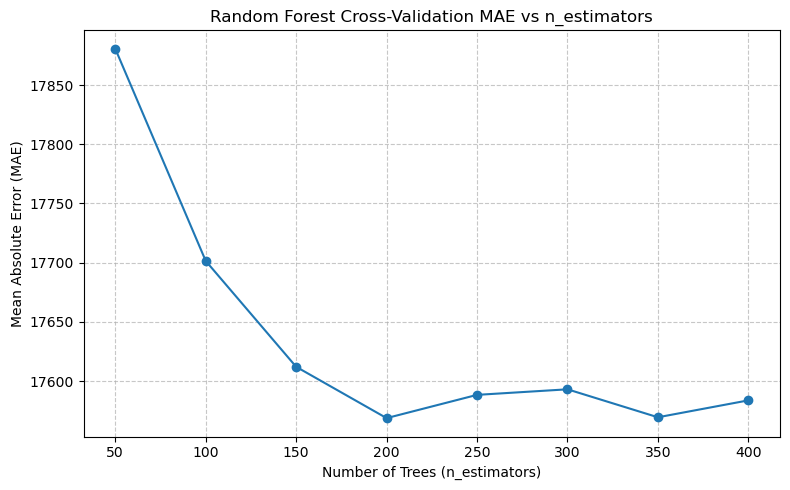

In [11]:
# Define the range of n_estimators to evaluate
n_estimators_range = range(50, 401, 50)

# Compute cross-validated MAE for each n_estimators value
rf_cv_scores = {n: get_rf_score(n) for n in n_estimators_range}

# Find the best n_estimators (with the lowest MAE)
best_n_estimators = min(rf_cv_scores, key=rf_cv_scores.get)
print(f"Best n_estimators: {best_n_estimators} with CV score: {rf_cv_scores[best_n_estimators]}")

# Train and evaluate the Random Forest pipeline with the best parameter
rf_pipeline = get_rf_pipeline(n_estimators=best_n_estimators)
rf_pipeline.fit(X, y)
rf_mae = evaluate_mae(rf_pipeline, X=X, y=y)

# Plot the cross-validation results
plt.figure(figsize=(8, 5))
plt.plot(list(rf_cv_scores.keys()), list(rf_cv_scores.values()), marker='o', linestyle='-')
plt.title('Random Forest Cross-Validation MAE vs n_estimators')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(list(rf_cv_scores.keys()))
plt.tight_layout()
plt.show()

### XGBoost model

In [12]:
def get_xgb_score(n_estimators, learning_rate, max_depth):
    """
    Returns the average MAE over 5-fold cross-validation for an XGBoost model.

    Parameters:
    n_estimators (int): Number of trees in the model.
    learning_rate (float): Learning rate for boosting.
    max_depth (int): Maximum depth of the trees.

    Returns:
    float: Mean Absolute Error averaged over 5 folds.
    """
    pipeline = get_xgb_pipeline(
        n_estimators=n_estimators, 
        learning_rate=learning_rate,
        max_depth=max_depth
    )
    
    # Perform cross-validation and calculate MAE
    scores = -1 * cross_val_score(
        pipeline, X, y, cv=5, scoring='neg_mean_absolute_error'
    )
    
    return scores.mean()

In [13]:
# Define parameter grids
n_estimators_list = range(500, 801, 50)
learning_rates = [0.01, 0.02, 0.03, 0.05, 0.1]
max_depths = [6]

# Compute cross-validated MAE for each parameter combination
cv_scores = {}
combinations = itertools.product(n_estimators_list, learning_rates, max_depths)
for n_estimators, learning_rate, max_depth in combinations:
    mae = get_xgb_score(n_estimators, learning_rate, max_depth)
    cv_scores[(n_estimators, learning_rate, max_depth)] = mae
    
p1, p2, p3 = min(cv_scores, key=cv_scores.get)
print(f"Best parameters: n_estimators={p1}, learning_rate={p2}, max_depth={p3} with CV score: {cv_scores[(p1, p2, p3)]}")

xgb_pipeline = get_xgb_pipeline(n_estimators=p1, learning_rate=p2, max_depth=p3)
xgb_pipeline.fit(X, y)
xgb_mae = evaluate_mae(xgb_pipeline, X=X, y=y)

Best parameters: n_estimators=700, learning_rate=0.02, max_depth=6 with CV score: 15500.8796875
MAE: 3309.42


## Submission

In [ ]:
# Create a DataFrame with test predictions and save to CSV
selected_pipeline = xgb_pipeline if xgb_mae < rf_mae else rf_pipeline
y_predictions = selected_pipeline.predict(X_test)
y_test = np.expm1(y_predictions) if is_transformed else y_predictions

submission = pd.DataFrame({
    'Id': X_test.index,
    'SalePrice': y_test
})
submission.to_csv('submission.csv', index=False)

: 